In [1]:
!pip install -q torchgeometry
!pip install -q segmentation-models-pytorch

In [2]:
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode
from collections import OrderedDict
from torchvision import transforms
from tqdm import tqdm
import wandb

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


# Parameters

In [5]:
num_classes = 3

# Number of epochs
epochs = 100

# Hyperparameters for training 
learning_rate = 1e-04
batch_size = 8
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/deeplab/pytorch/default/3/deeplabv3_polyp.pth"



# Dataloader

In [6]:
transform = transforms.Compose([Resize((512, 512), interpolation=InterpolationMode.BILINEAR),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [7]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path).convert('RGB')
        label = Image.open(mask_path).convert('RGB')
        
        # Normalize
        data = self.transform(data) 
        label = self.transform(label) 
        
        label = torch.where(label>0.65, 1.0, 0.0)
        
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [8]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

In [9]:
unet_dataset = UNetDataClass(images_path, masks_path, transform)
train_size = 0.9
valid_size = 0.1

# Data Augmentation

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/tmp/ipykernel_23/1958139749.py:11: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


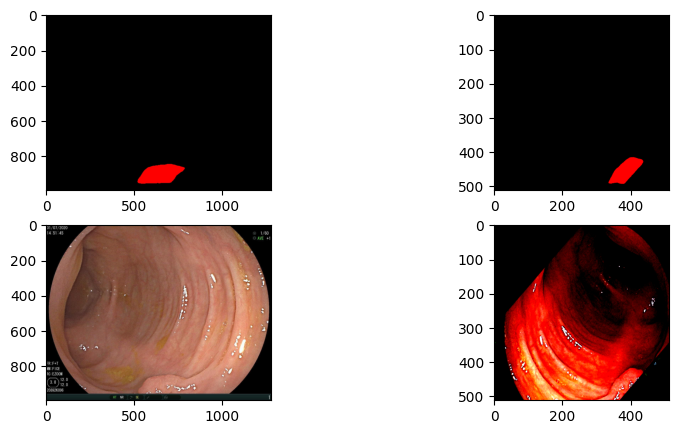

In [10]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),  # Horizontal Flip
    A.RandomRotate90(p=0.5),  # Random 90-degree rotation
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Gaussian blur
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.CoarseDropout(max_holes=1, max_height=35, max_width=35, fill_value=255, p=0.2)

])

image = Image.open('/kaggle/input/bkai-igh-neopolyp/train/train/0081835cf877e004e8bfb905b78a9139.jpeg').convert('RGB')
image = np.array(image)

mask = Image.open('/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/0081835cf877e004e8bfb905b78a9139.jpeg').convert('RGB')
mask = np.array(mask)

# Apply the augmentation pipeline
augmented = augmentation_pipeline(image=image, mask=mask)
augmented_image = Image.fromarray(augmented['image'])
augmented_mask = Image.fromarray(augmented['mask'])

# augmented_mask = augmented_mask.permute(2,0,1)
augmented_image = transform(augmented_image)
augmented_mask = transform(augmented_mask)

# print(augmented_mask.shape) 

# Display original and augmented images
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(mask)
ax[0][1].imshow(augmented_mask.permute(1,2, 0).numpy())  # permute to (H, W, C) for visualization
ax[1][0].imshow(image)
ax[1][1].imshow(augmented_image.permute(1,2,0).numpy())
plt.show()


In [11]:
class SegDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform=None, augmentation=None):
        super(SegDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [os.path.join(images_path, image_name) for image_name in images_list]
        masks_list = [os.path.join(masks_path, mask_name) for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.augmentation = augmentation
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path).convert('RGB')
        label = Image.open(mask_path).convert('RGB')
        
        # Augmentation
        if self.augmentation:
            augmented = self.augmentation(image=np.array(data), mask=np.array(label))
            data = Image.fromarray(augmented['image'])
            label = Image.fromarray(augmented['mask'])
        
        # Normalize
        data = self.transform(data)
        label = self.transform(label)
        
        label = torch.where(label > 0.65, 1.0, 0.0)
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)


In [12]:
torch.manual_seed(42)

In [13]:
from torch.utils.data import ConcatDataset

aug_dataset1 = SegDataClass(images_path, masks_path, transform=transform, augmentation=augmentation_pipeline)
aug_dataset = ConcatDataset([aug_dataset1, unet_dataset])

train_size = 0.9 
valid_size = 0.1
train_aug_set, valid_aug_set = random_split(aug_dataset, 
                                    [int(train_size * len(aug_dataset)) , 
                                     int(valid_size * len(aug_dataset))])
print(len(train_aug_set))

train_dataloader = DataLoader(train_aug_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_aug_set, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))

1800
225


0


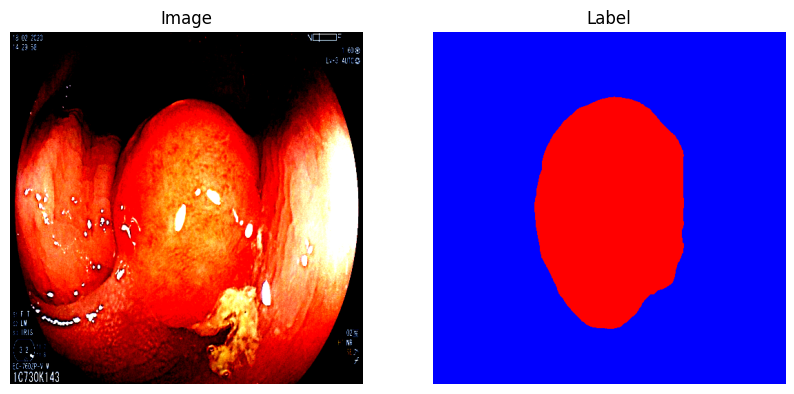

In [14]:
for images, labels in valid_dataloader: 
    images = images[0]
    labels = labels[0]
    # label_array = label.permute(1, 2, 0).cpu().numpy()
    image_array = images.permute(1, 2, 0).cpu().numpy()
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    count = (labels.long() == 1).sum().item()
    print(count)
    
    axs[0].imshow(image_array)
    axs[0].set_title('Image')
    axs[0].axis('off')  
    
    axs[1].imshow(F.one_hot(labels).float())
    axs[1].set_title('Label')
    axs[1].axis('off')  
    plt.show()
    break

# Loss function

In [15]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return 0.6*torch.mean(1. - dice_score) + 0.4*celoss


# Training

**Initialize weights**

In [16]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

In [17]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    return model

**Train model**

In [18]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 99
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= len(valid_dataloader)
    
    return train_loss_epoch , test_loss_epoch

In [19]:
try:
    checkpoint = torch.load(pretrained_path, weights_only = True)

    new_state_dict = OrderedDict()
    for k, v in checkpoint['model'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)
    model = nn.DataParallel(model)
    model.to(device)
except:
    model.apply(weights_init)
    model = nn.DataParallel(model)
    model.to(device)

In [20]:
weights = torch.Tensor([[0.45, 0.45, 0.1]]).cuda()
loss_function = CEDiceLoss(weights)

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)


In [ ]:

wandb.login(key = '')
wandb.init(project = 'polypsegmentation', 
          name = 'DeepLabV3+_resnest50')
# Training loop
torch.cuda.empty_cache()
last_loss = 99
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hung123ka5. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241230_154944-b2cy212f
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run DeepLabV3+_resnest50
wandb: ⭐️ View project at https://wandb.ai/hung123ka5/polypsegmentation
wandb: 🚀 View run at https://wandb.ai/hung123ka5/polypsegmentation/runs/b2cy212f


Start epoch #1, learning rate for this epoch: [0.0001]


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Train Epoch: 1 [400/1800 (22.22222222222222%)]	Loss: 0.5308
Train Epoch: 1 [800/1800 (44.44444444444444%)]	Loss: 0.3442
Train Epoch: 1 [1200/1800 (66.66666666666667%)]	Loss: 0.4694
Train Epoch: 1 [1600/1800 (88.88888888888889%)]	Loss: 0.4731
Done epoch #1, time for this epoch: 321.8623824119568s
Start epoch #2, learning rate for this epoch: [0.0001]
Train Epoch: 2 [400/1800 (22.22222222222222%)]	Loss: 0.3447
Train Epoch: 2 [800/1800 (44.44444444444444%)]	Loss: 0.3642
Train Epoch: 2 [1200/1800 (66.66666666666667%)]	Loss: 0.3746
Train Epoch: 2 [1600/1800 (88.88888888888889%)]	Loss: 0.3261
Done epoch #2, time for this epoch: 306.3973295688629s
Start epoch #3, learning rate for this epoch: [0.0001]
Train Epoch: 3 [400/1800 (22.22222222222222%)]	Loss: 0.4248
Train Epoch: 3 [800/1800 (44.44444444444444%)]	Loss: 0.3957
Train Epoch: 3 [1200/1800 (66.66666666666667%)]	Loss: 0.3363
Train Epoch: 3 [1600/1800 (88.88888888888889%)]	Loss: 0.3887
Done epoch #3, time for this epoch: 300.44759941101074

# Visualization

tensor(0.2680, device='cuda:0')


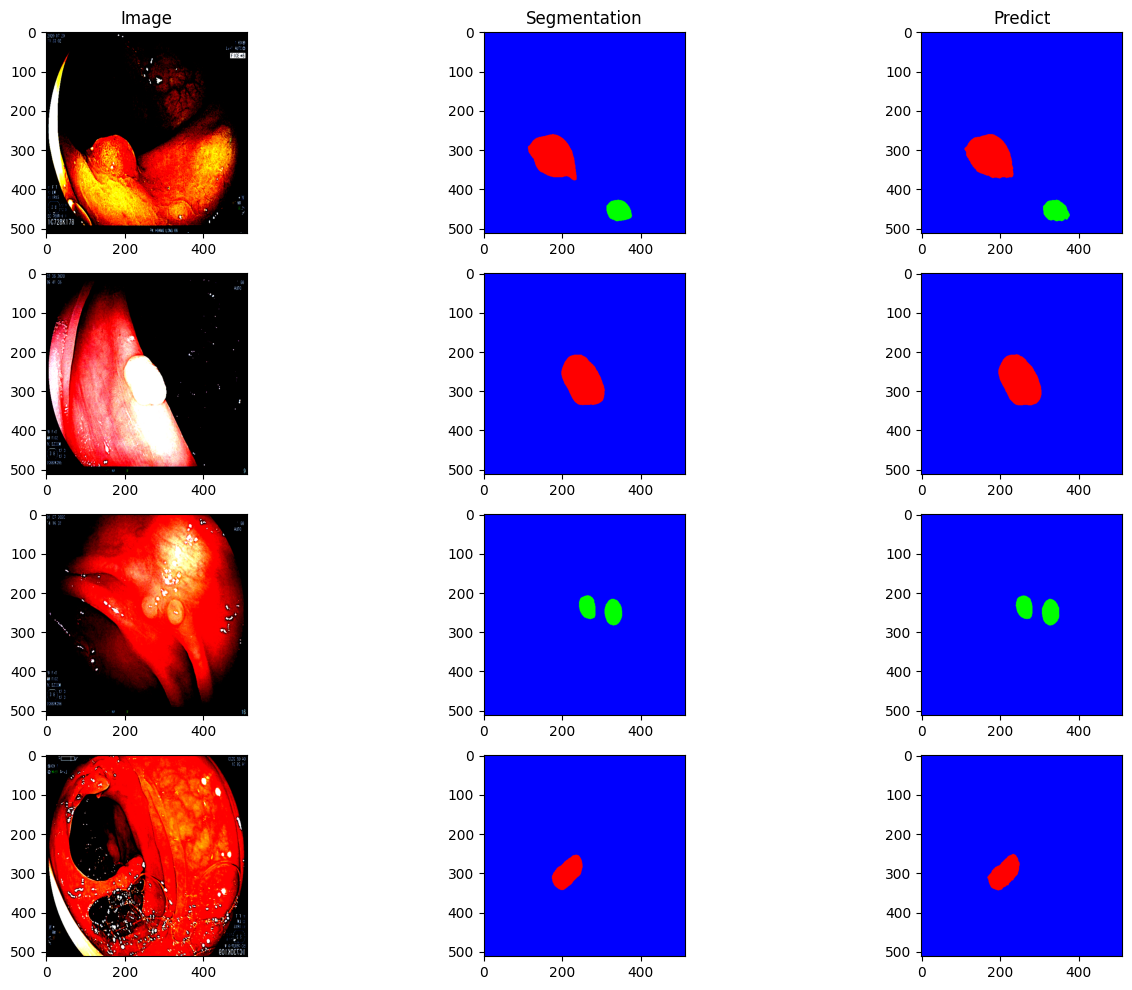

In [22]:
fig, arr = plt.subplots(4, 3, figsize=(16, 12))
arr[0][0].set_title('Image')
arr[0][1].set_title('Segmentation')
arr[0][2].set_title('Predict')
model.eval()
for i, (data, label) in enumerate(valid_dataloader):
    img = data
    mask = label
    img2 = img.to(device)
    with torch.no_grad():
        lateral_map_2 = model(img2)
        res = lateral_map_2        
        loss = loss_function(res, mask.cuda().long())
        print(loss)
    if i == 0: break

for i in range(4):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    
    arr[i][1].imshow(F.one_hot(mask[i]).float())
    
    arr[i][2].imshow(F.one_hot(torch.argmax(res[i], 0).cpu()).float())

In [23]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data)    
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [24]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=False)

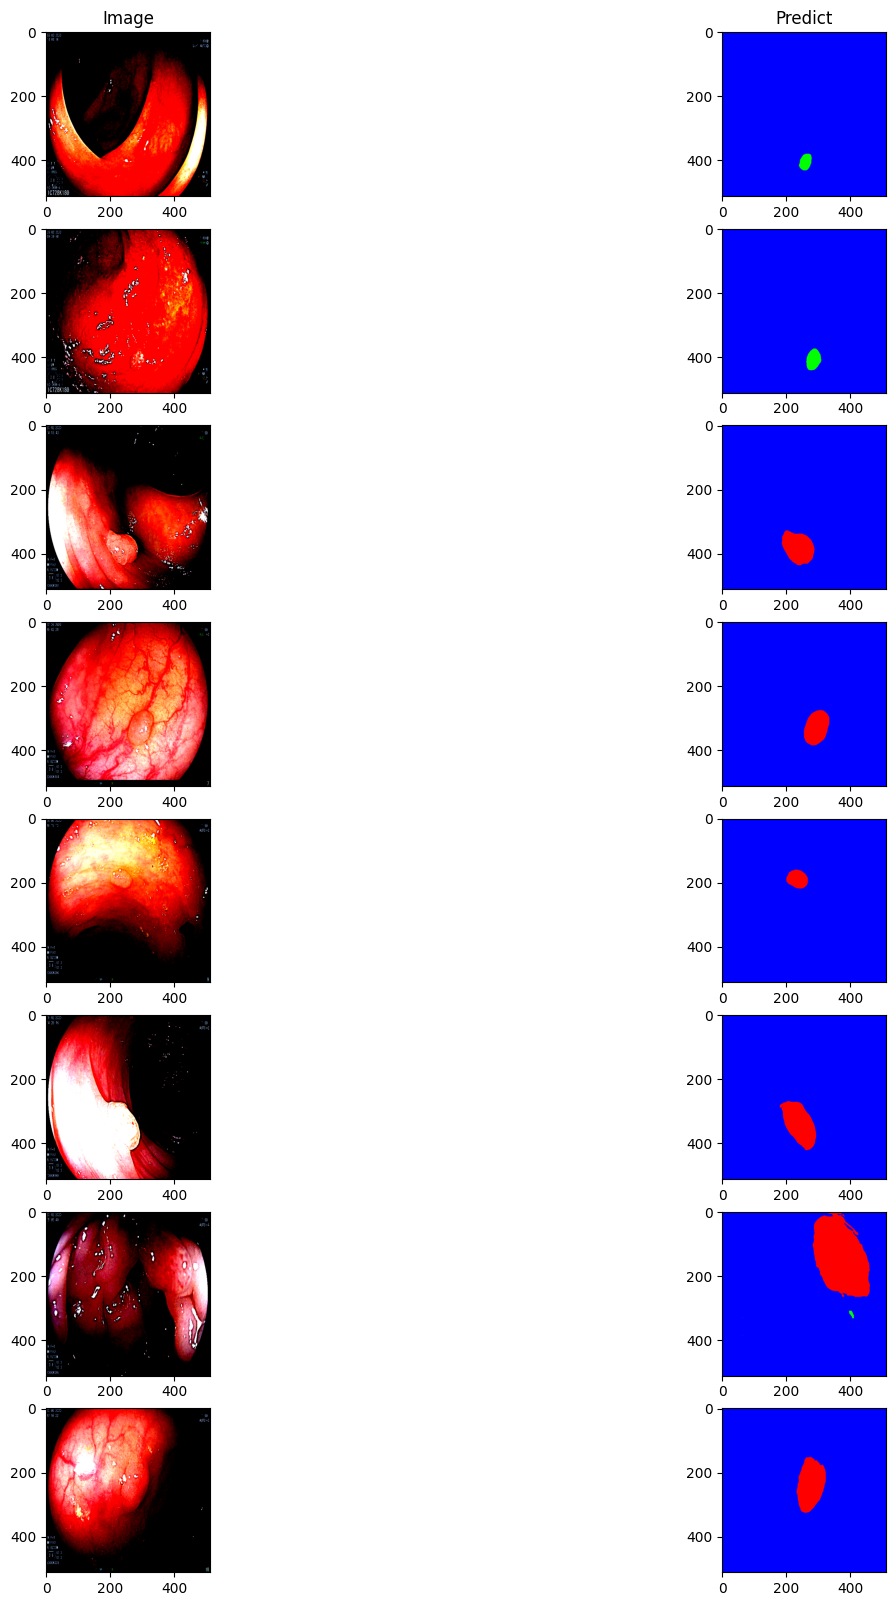

In [25]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    if i == 1: break
    
fig, arr = plt.subplots(8, 2, figsize=(16, 20))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(8):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())


## Process after (1 color - 1 block)

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def process_regions(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create mask for blue background
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Create masks for red and green
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    red_mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    red_mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    
    lower_green = np.array([40, 50, 50])
    upper_green = np.array([80, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Get non-blue regions
    non_blue_mask = cv2.bitwise_not(blue_mask)
    
    # Label connected components in non-blue regions
    labels, num_labels = ndimage.label(non_blue_mask)
    
    # Create result image
    result = np.zeros_like(image)
    result[blue_mask > 0] = [255, 0, 0]  # Set blue background
    
    # Process each labeled region
    for label in range(1, num_labels + 1):
        region_mask = (labels == label)
        
        # Count red and green pixels in this region
        red_count = cv2.countNonZero(cv2.bitwise_and(red_mask, region_mask.astype(np.uint8)))
        green_count = cv2.countNonZero(cv2.bitwise_and(green_mask, region_mask.astype(np.uint8)))
        
        # If only one color is present, use that color
        if red_count > 0 and green_count == 0:
            result[region_mask] = [0, 0, 255]  # Pure red
        elif green_count > 0 and red_count == 0:
            result[region_mask] = [0, 255, 0]  # Pure green
        # If mixed colors, use the dominant one
        else:
            if red_count > green_count:
                result[region_mask] = [0, 0, 255]  # Red
            else:
                result[region_mask] = [0, 255, 0]  # Green
    
    return result

In [27]:
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [28]:
processed_dir = '/kaggle/working/processed_masks_after'
os.mkdir("/kaggle/working/processed_masks_after")

result_path = '/kaggle/working/predicted_masks'
results = os.listdir(result_path)
for i in range (len(results)): 
    img_path = os.path.join(result_path, results[i])
    processed_path = os.path.join(processed_dir, results[i])
    image = cv2.imread(img_path) 
    image = process_regions(image) 
    cv2.imwrite(processed_path, image)


In [29]:
# processed_img_path = 'c7e610b1531871f2fd85a04faeeb2b53.png'
# processed_img_path = os.path.join(processed_dir, processed_img_path)
# img = cv2.imread(processed_img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)

In [30]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/processed_masks_after' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

/kaggle/working/processed_masks_after/e3c84417fda8019410b1fcf0625f608b.png
/kaggle/working/processed_masks_after/3b8318ecf467d7ad048df39beb176363.png
/kaggle/working/processed_masks_after/5beb48f0be11d0309d1dff09b8405734.png
/kaggle/working/processed_masks_after/98da48d679d7c7c8d3d96fb2b87fbbcf.png
/kaggle/working/processed_masks_after/15fc656702fa602bb3c7abacdbd7e6af.png
/kaggle/working/processed_masks_after/395e56a6d9ba9d45c3dbc695325ded46.png
/kaggle/working/processed_masks_after/cf6644589e532a9ee954f81faedbce39.png
/kaggle/working/processed_masks_after/f8e5ad89d2844837f2a0f1536ad3f6a5.png
/kaggle/working/processed_masks_after/1209db6dcdda5cc8a788edaeb6aa460a.png
/kaggle/working/processed_masks_after/8cbdf366e057db382b8564872a27301a.png
/kaggle/working/processed_masks_after/a6e51d077bad31c8c5f54ffaa27a6235.png
/kaggle/working/processed_masks_after/782707d7c359e27888daefee82519763.png
/kaggle/working/processed_masks_after/1531871f2fd85a04faeeb2b535797395.png
/kaggle/working/processed

In [31]:
pretrained_path = '/kaggle/working/unet_model.pth'
path = torch.load(pretrained_path)
model.load_state_dict(path['model'])

model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks2"):
    os.mkdir("/kaggle/working/predicted_masks2")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks2/", filename))

/tmp/ipykernel_23/3236641851.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  path = torch.load(pretrained_path)
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel

In [32]:
processed_dir = '/kaggle/working/processed_masks_after2'
os.mkdir("/kaggle/working/processed_masks_after2")

result_path = '/kaggle/working/predicted_masks2'
results = os.listdir(result_path)
for i in range (len(results)): 
    img_path = os.path.join(result_path, results[i])
    processed_path = os.path.join(processed_dir, results[i])
    image = cv2.imread(img_path) 
    image = process_regions(image) 
    cv2.imwrite(processed_path, image)


In [33]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/processed_masks_after2' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output2.csv', index=False)

/kaggle/working/processed_masks_after2/e3c84417fda8019410b1fcf0625f608b.png
/kaggle/working/processed_masks_after2/3b8318ecf467d7ad048df39beb176363.png
/kaggle/working/processed_masks_after2/5beb48f0be11d0309d1dff09b8405734.png
/kaggle/working/processed_masks_after2/98da48d679d7c7c8d3d96fb2b87fbbcf.png
/kaggle/working/processed_masks_after2/15fc656702fa602bb3c7abacdbd7e6af.png
/kaggle/working/processed_masks_after2/395e56a6d9ba9d45c3dbc695325ded46.png
/kaggle/working/processed_masks_after2/cf6644589e532a9ee954f81faedbce39.png
/kaggle/working/processed_masks_after2/f8e5ad89d2844837f2a0f1536ad3f6a5.png
/kaggle/working/processed_masks_after2/1209db6dcdda5cc8a788edaeb6aa460a.png
/kaggle/working/processed_masks_after2/8cbdf366e057db382b8564872a27301a.png
/kaggle/working/processed_masks_after2/a6e51d077bad31c8c5f54ffaa27a6235.png
/kaggle/working/processed_masks_after2/782707d7c359e27888daefee82519763.png
/kaggle/working/processed_masks_after2/1531871f2fd85a04faeeb2b535797395.png
/kaggle/work